In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

from sklearn.metrics import r2_score, balanced_accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
LABELS = pd.read_csv('data/labels.csv')
LABELS['pTau_Positivity'] = pd.read_csv('data/plasma_labels.csv')['pTau_Positivity']
SMOTE = BorderlineSMOTE()

In [3]:
def load_raw_data(csv_path: str, feat_to_predict: str, check: str):
    # Load the entire csv file
    data = pd.read_csv(csv_path)

    # Join labels and data so that truth values are aligned with original data
    lbls = LABELS[['id', feat_to_predict, check]] 
    temp = data.merge(lbls, on='id', how='left')
    temp = temp.dropna()
    print(f'Final dataset dimension: {len(temp)}')
    # Extract only the ground truths
    labels = pd.DataFrame(temp[feat_to_predict], columns=[feat_to_predict])
    data = temp.drop([feat_to_predict, check], axis=1)
    data = data.set_index('id')
    data = pd.DataFrame(StandardScaler().fit_transform(data), columns=data.columns, index=data.index)

    if feat_to_predict == 'Sex_Category':
        labels['Sex_Category'] = labels['Sex_Category'].map({'Male': 0, 'Female': 1})

    return data, labels

In [4]:
def train_and_test(X, y, model, scoring_f, smote):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y if smote else None)
    if smote: X_train, y_train = SMOTE.fit_resample(X_train, y_train)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return scoring_f(y_test, y_pred)


In [5]:
def evaluate(dataset: str, target: str, features: list[str], check: str):
    X, y = load_raw_data(f'data/{dataset}', target, check)
    X = X[features]
    regr = len(y[target].value_counts()) > 2

    model = LinearRegression() if regr else SVC()
    scoring_f = r2_score if regr else balanced_accuracy_score
    metric = 'R2 Score' if regr else "Accuracy"

    results = []
    for _ in range(1000):
        results.append(train_and_test(X, y[target], model, scoring_f, not regr))

    avg, stdev, sk, krt = np.mean(results), np.std(results), stats.skew(results), stats.kurtosis(results)
    print(f'  - {metric} Average:   {"" if avg<0 else " "}{avg:0.4f}')
    print(f'  - {metric} StDev:     {"" if stdev<0 else " "}{stdev:0.4f}')
    print(f'  - {metric} Skew:      {"" if sk<0 else " "}{sk:0.4f}')
    print(f'  - {metric} Kurtosis:  {"" if krt<0 else " "}{krt:0.4f}')
    print()

In [6]:
def plot(data: pd.DataFrame, target: str, cols: list[str]):
    ROW, COL = 2, 4
    fig, ax = plt.subplots(ROW,COL,figsize=(16,8))
    fig.tight_layout(pad=4.0)
    for row in range(ROW):
        for col in range(COL):
            if target == 'Sex_Category':
                chart = sns.boxplot(data=data, x=target, y=cols[row*ROW + col], ax=ax[row][col])
                chart.set(xlabel=None)
            else:
                sns.scatterplot(data=data, x=cols[row*ROW + col], y=target, ax=ax[row][col])
    plt.show()

In [7]:
def visualize(data: str, target: str, feats: list[str], check: str):
    X, y = load_raw_data(f'data/{data}', target, check)
    X[target] = y[target].to_list()
    if target == 'Sex_Category':
        X['Sex_Category'] = X['Sex_Category'].map({0: 'Male', 1: 'Female'})
    plot(X, target, feats)

# MOCA_impairment features

Age
Final dataset dimension: 91
  - R2 Score Average:   -0.2770
  - R2 Score StDev:      0.2474
  - R2 Score Skew:      -2.5998
  - R2 Score Kurtosis:   12.7902

Final dataset dimension: 91


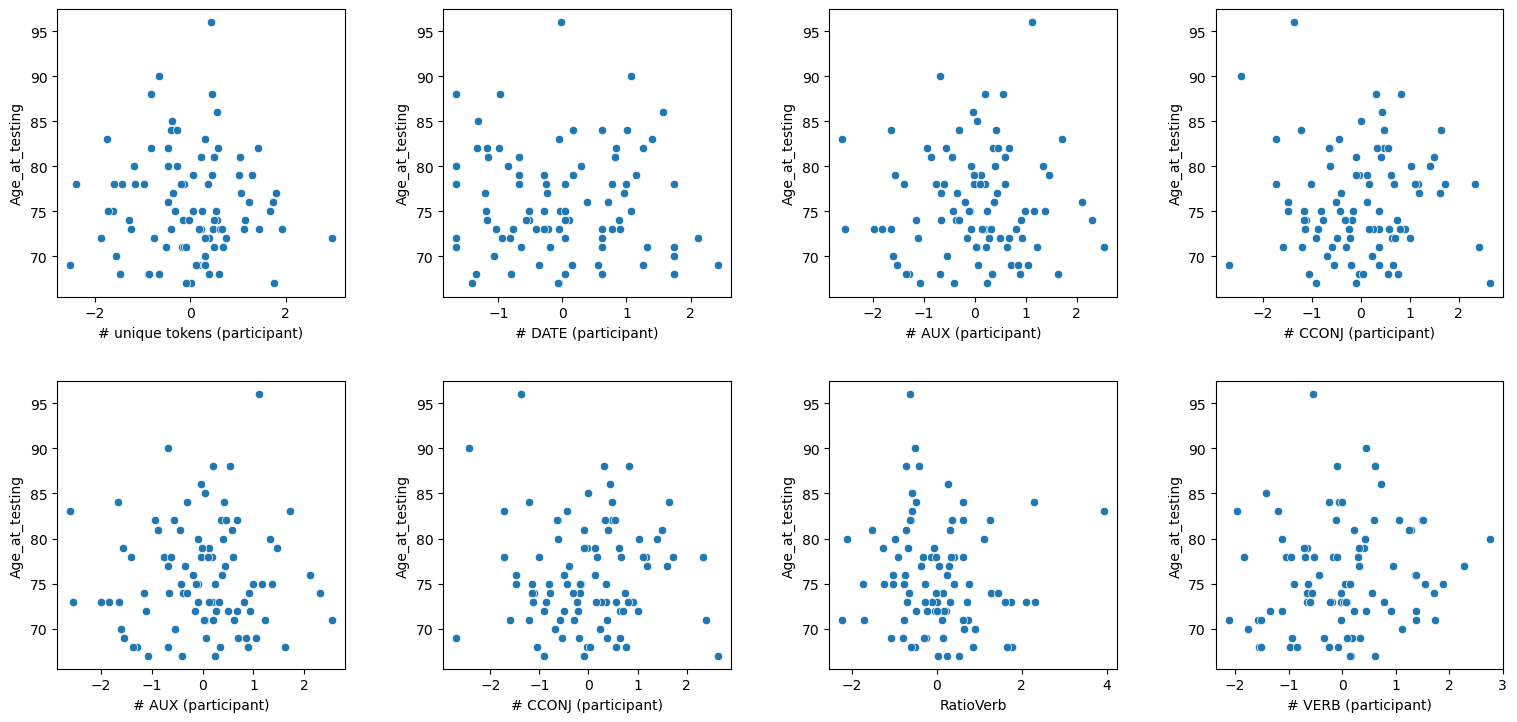

Gender
Final dataset dimension: 91
  - Accuracy Average:    0.6459
  - Accuracy StDev:      0.0759
  - Accuracy Skew:      -0.2079
  - Accuracy Kurtosis:  -0.0475

Final dataset dimension: 91


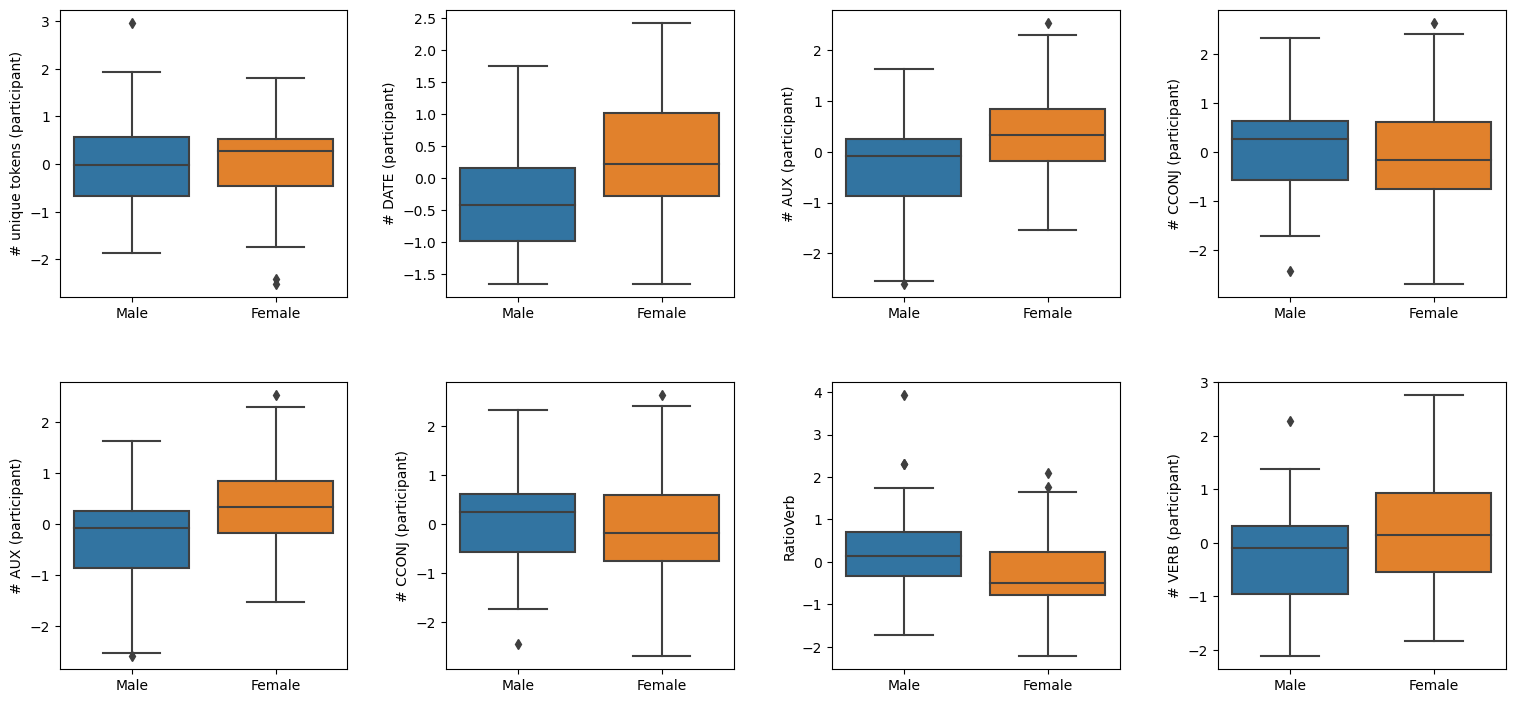

Education
Final dataset dimension: 91
  - R2 Score Average:   -0.2698
  - R2 Score StDev:      0.2733
  - R2 Score Skew:      -1.8998
  - R2 Score Kurtosis:   6.0855

Final dataset dimension: 91


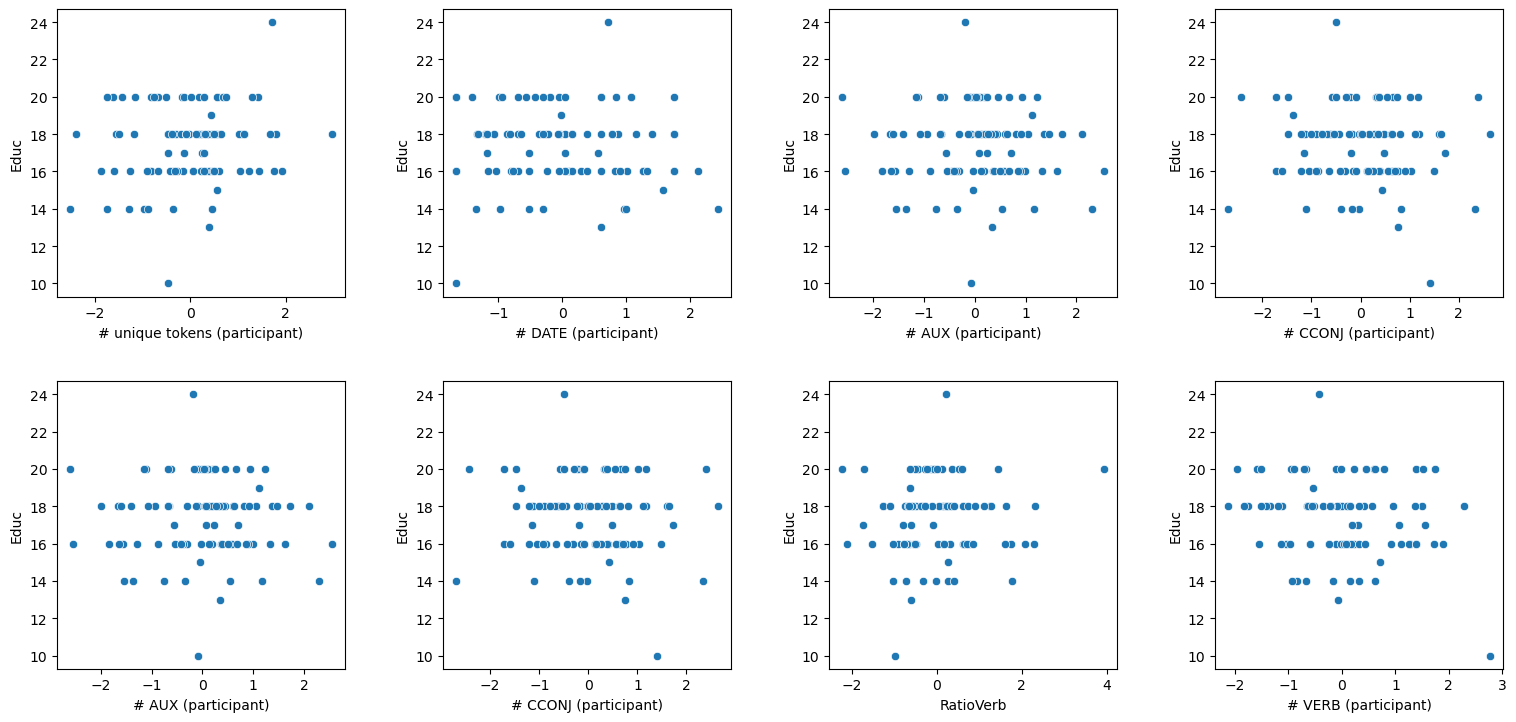

In [8]:
dataset = 'no_audio_corrected.csv'
feats = [
    '# unique tokens (participant)', '# DATE (participant)', '# AUX (participant)', '# CCONJ (participant)',
    'RatioVerb', '# VERB (participant)', 'proportion_below_threshold_0.5', 'VP_to_AUX_ADJP (participant)'
]

print('Age')
evaluate(dataset, 'Age_at_testing', feats, 'MOCA_impairment')
visualize(dataset, 'Age_at_testing', feats, 'MOCA_impairment')

print('Gender')
evaluate(dataset, 'Sex_Category', feats, 'MOCA_impairment')
visualize(dataset, 'Sex_Category', feats, 'MOCA_impairment')

print('Education')
evaluate(dataset, 'Educ', feats, 'MOCA_impairment')
visualize(dataset, 'Educ', feats, 'MOCA_impairment')


# AB<sub>42</sub>/AB<sub>40</sub>

Age
Final dataset dimension: 63
  - R2 Score Average:   -0.5057
  - R2 Score StDev:      0.4526
  - R2 Score Skew:      -2.2371
  - R2 Score Kurtosis:   9.0021

Final dataset dimension: 63


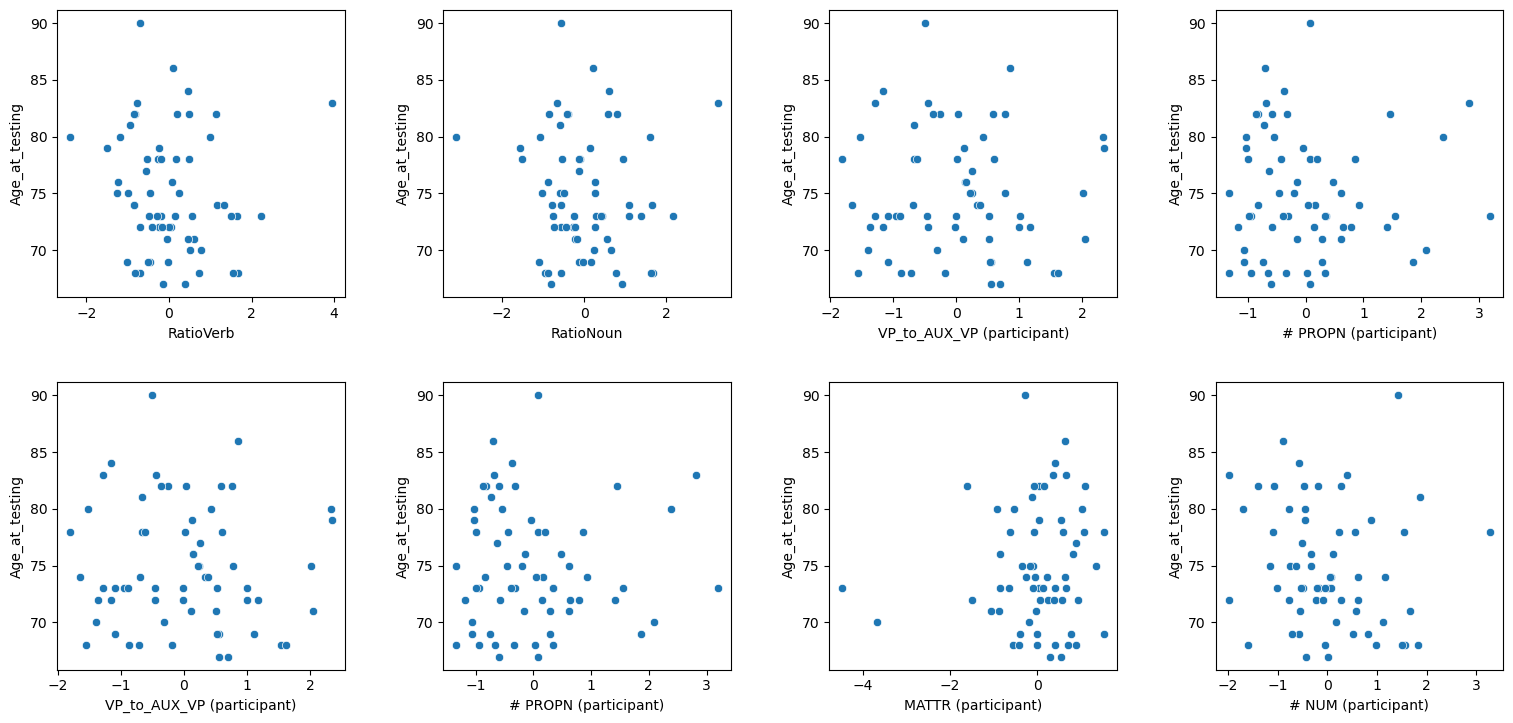

Gender
Final dataset dimension: 63
  - Accuracy Average:    0.6820
  - Accuracy StDev:      0.0909
  - Accuracy Skew:      -0.1456
  - Accuracy Kurtosis:   0.0954

Final dataset dimension: 63


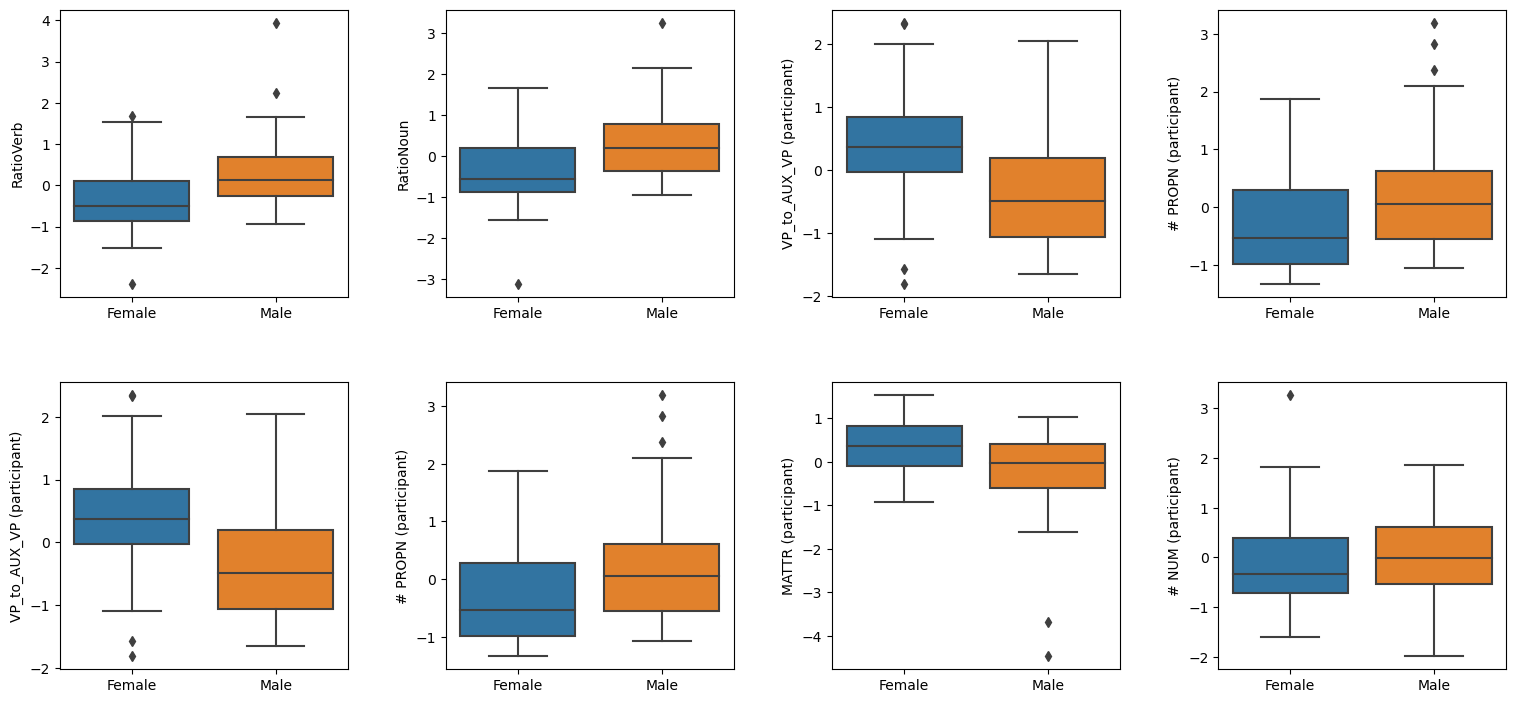

Education
Final dataset dimension: 63
  - R2 Score Average:   -0.5700
  - R2 Score StDev:      0.6313
  - R2 Score Skew:      -2.8784
  - R2 Score Kurtosis:   14.1844

Final dataset dimension: 63


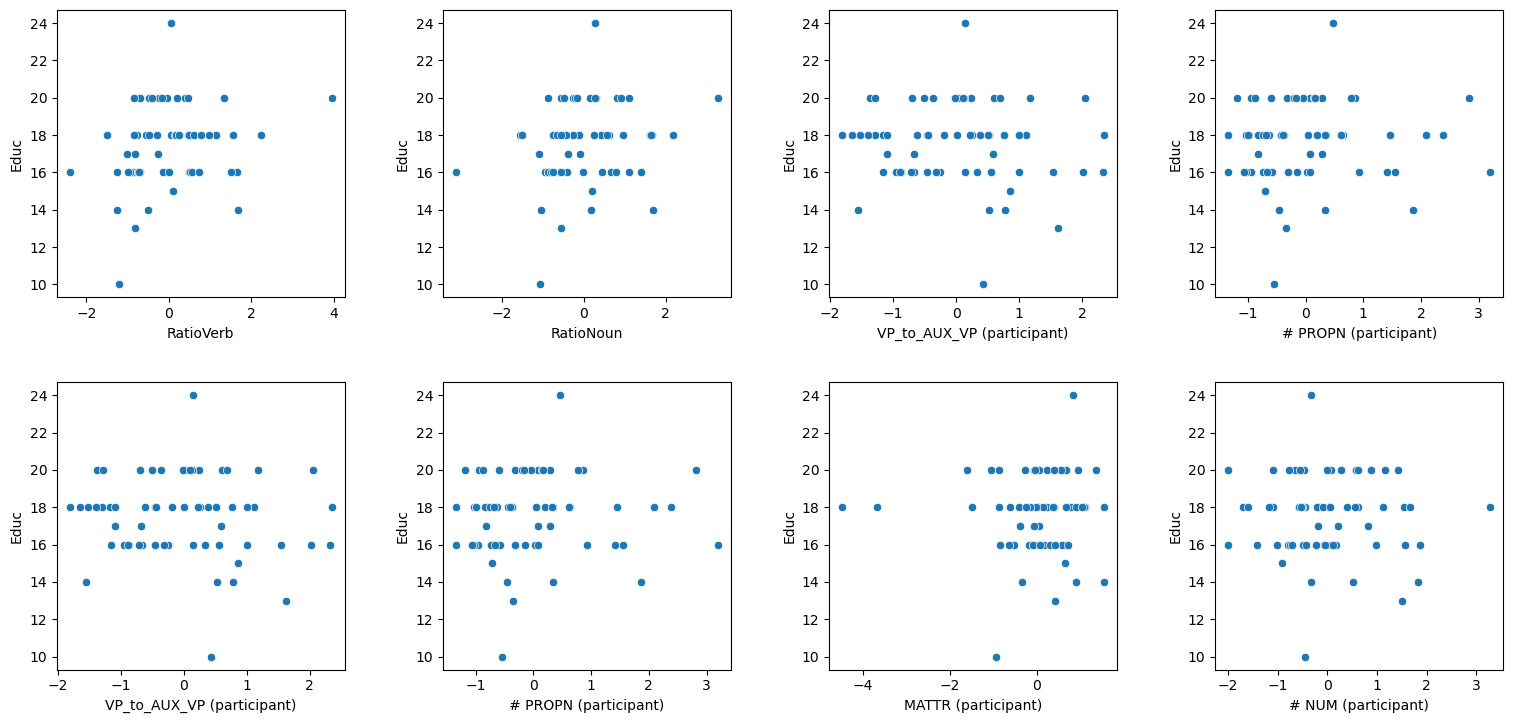

In [9]:
dataset = 'no_audio_corrected.csv'
feats = [
    'RatioVerb', 'RatioNoun', 'VP_to_AUX_VP (participant)', '# PROPN (participant)', 'MATTR (participant)',
    '# NUM (participant)', '# TIME (participant)', '# unique tokens (participant)', 'VPTypeRate'
]

print('Age')
evaluate(dataset, 'Age_at_testing', feats, 'AB42_AB40Positivity')
visualize(dataset, 'Age_at_testing', feats, 'AB42_AB40Positivity')

print('Gender')
evaluate(dataset, 'Sex_Category', feats, 'AB42_AB40Positivity')
visualize(dataset, 'Sex_Category', feats, 'AB42_AB40Positivity')

print('Education')
evaluate(dataset, 'Educ', feats, 'AB42_AB40Positivity')
visualize(dataset, 'Educ', feats, 'AB42_AB40Positivity')

# tTau/AB<sub>42</sub>

Age
Final dataset dimension: 63
  - R2 Score Average:   -0.7751
  - R2 Score StDev:      0.9242
  - R2 Score Skew:      -5.1891
  - R2 Score Kurtosis:   53.1261

Final dataset dimension: 63


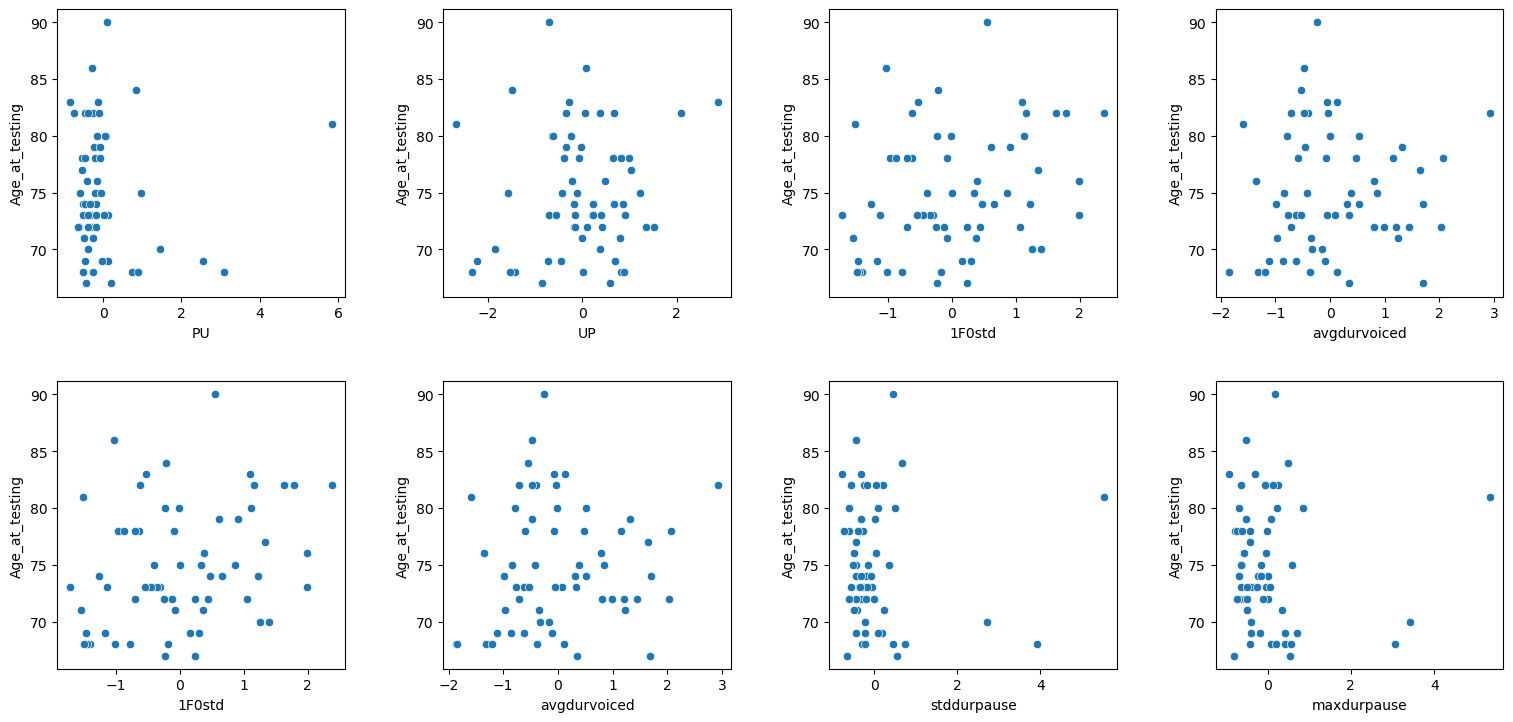

Gender
Final dataset dimension: 63
  - Accuracy Average:    0.5098
  - Accuracy StDev:      0.0949
  - Accuracy Skew:      -0.1647
  - Accuracy Kurtosis:  -0.1067

Final dataset dimension: 63


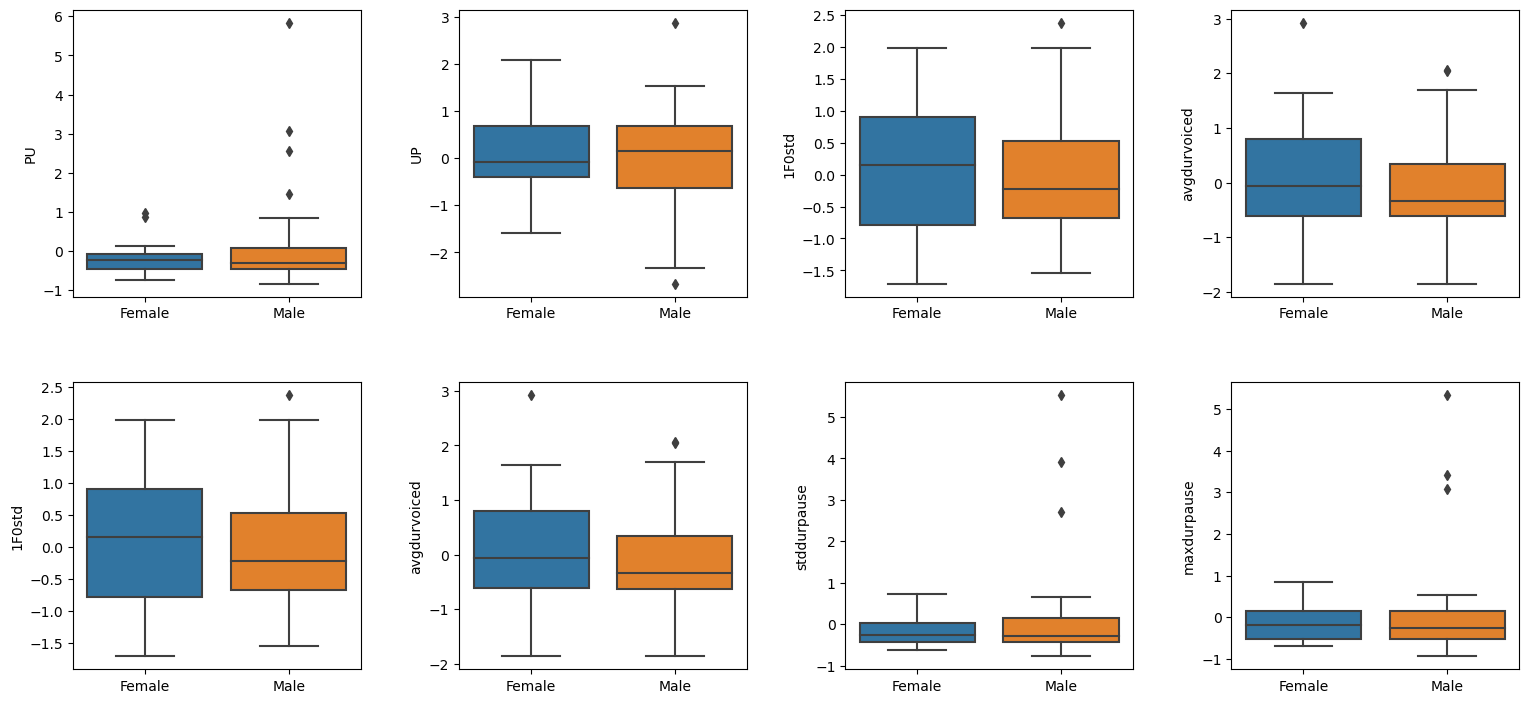

Education
Final dataset dimension: 63
  - R2 Score Average:   -0.4719
  - R2 Score StDev:      0.9510
  - R2 Score Skew:      -7.1426
  - R2 Score Kurtosis:   74.5743

Final dataset dimension: 63


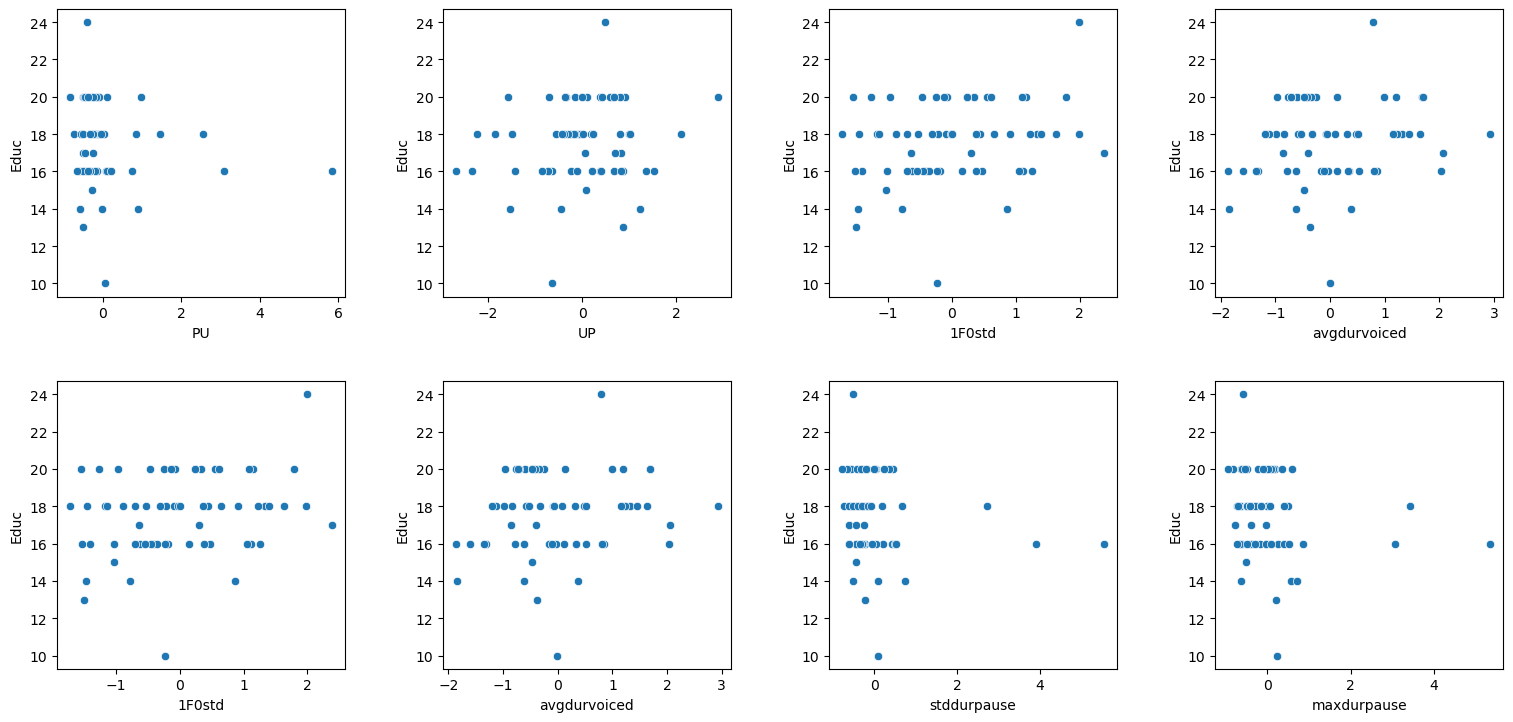

In [10]:
dataset = 'full_corrected.csv'
feats = [
    'PU', 'UP', '1F0std', 'avgdurvoiced', 'stddurpause', 'maxdurpause', 'PVU', 'VP'
]

print('Age')
evaluate(dataset, 'Age_at_testing', feats, 'tTau_AB42Positivity')
visualize(dataset, 'Age_at_testing', feats, 'tTau_AB42Positivity')

print('Gender')
evaluate(dataset, 'Sex_Category', feats, 'tTau_AB42Positivity')
visualize(dataset, 'Sex_Category', feats, 'tTau_AB42Positivity')

print('Education')
evaluate(dataset, 'Educ', feats, 'tTau_AB42Positivity')
visualize(dataset, 'Educ', feats, 'tTau_AB42Positivity')

# pTau

Age
Final dataset dimension: 76
  - R2 Score Average:   -0.5863
  - R2 Score StDev:      0.5033
  - R2 Score Skew:      -2.2398
  - R2 Score Kurtosis:   9.0158

Final dataset dimension: 76


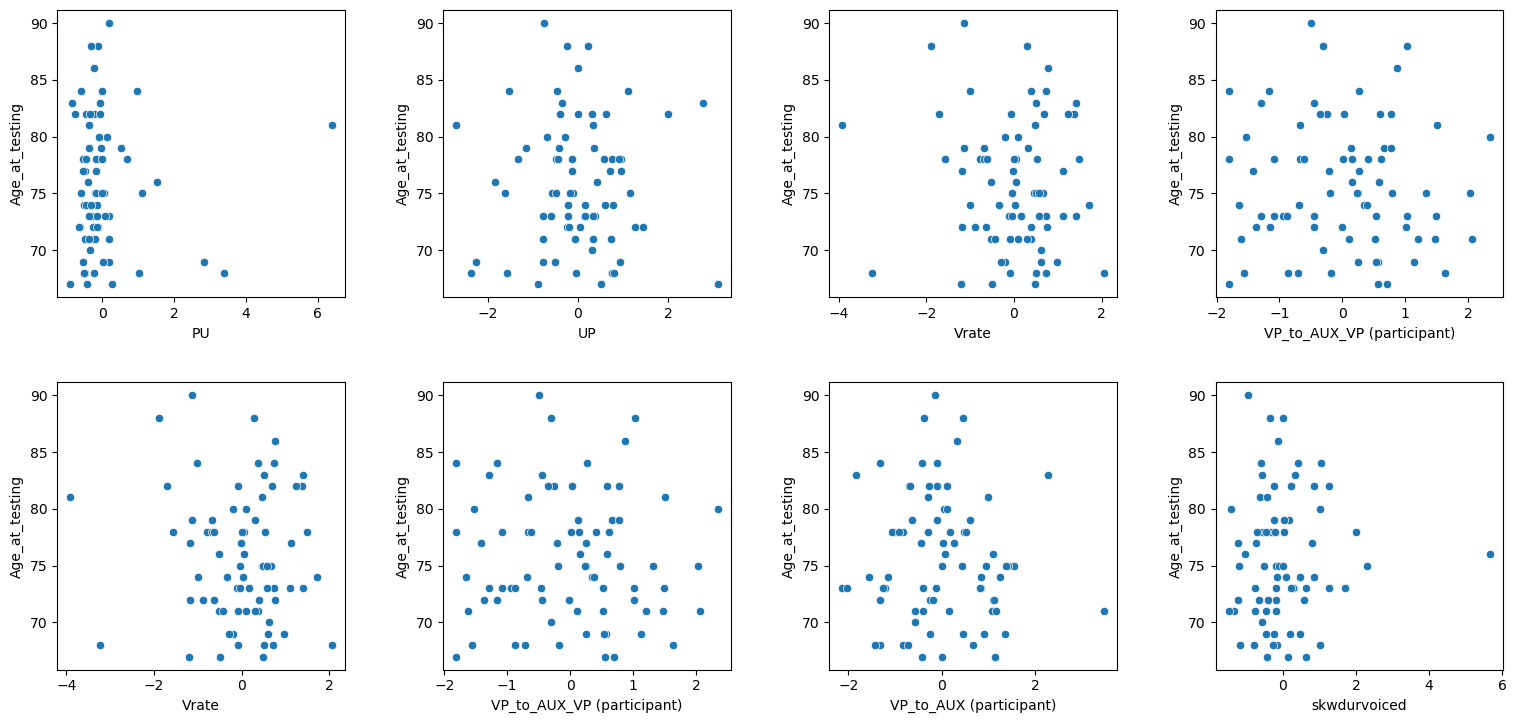

Gender
Final dataset dimension: 76
  - Accuracy Average:    0.7167
  - Accuracy StDev:      0.0775
  - Accuracy Skew:      -0.1329
  - Accuracy Kurtosis:   0.0163

Final dataset dimension: 76


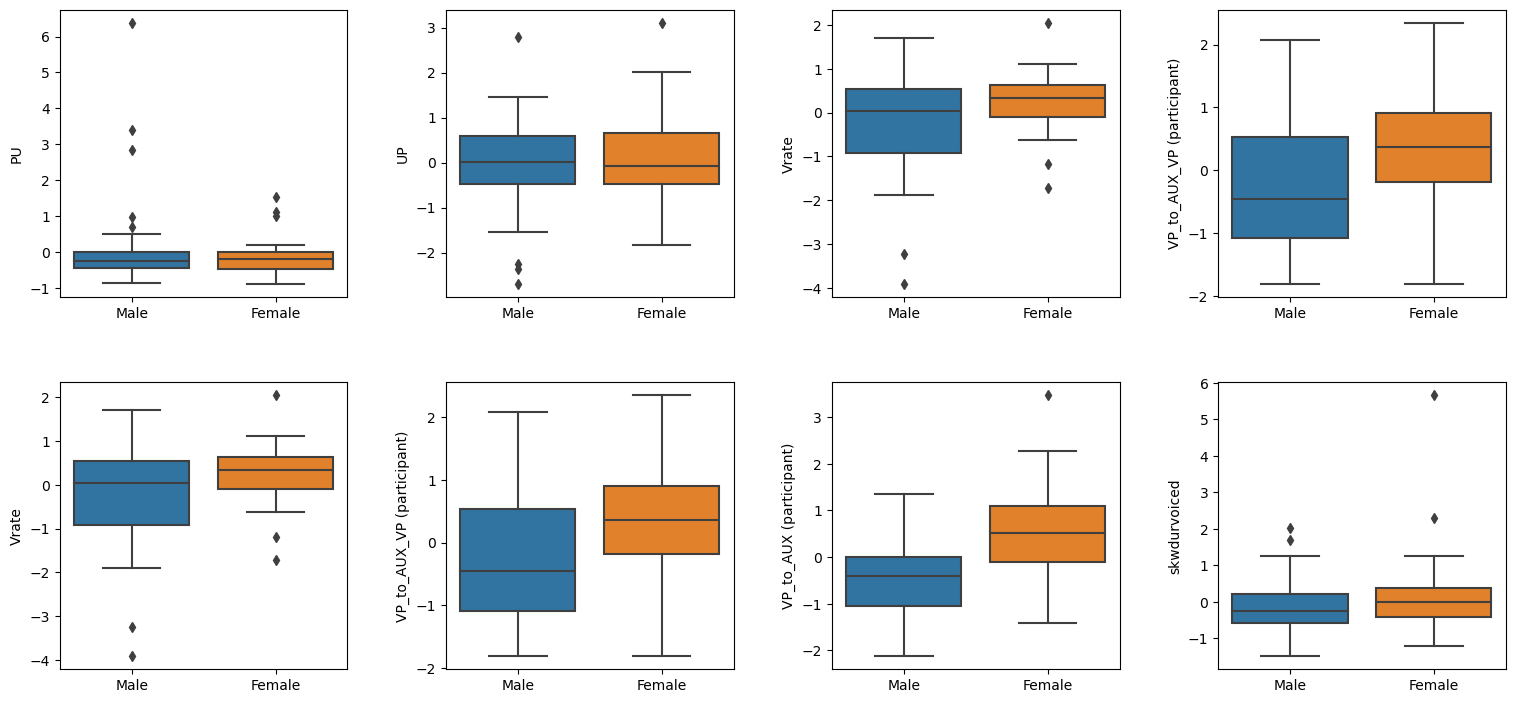

Education
Final dataset dimension: 76
  - R2 Score Average:   -0.5421
  - R2 Score StDev:      0.7204
  - R2 Score Skew:      -6.2745
  - R2 Score Kurtosis:   64.4653

Final dataset dimension: 76


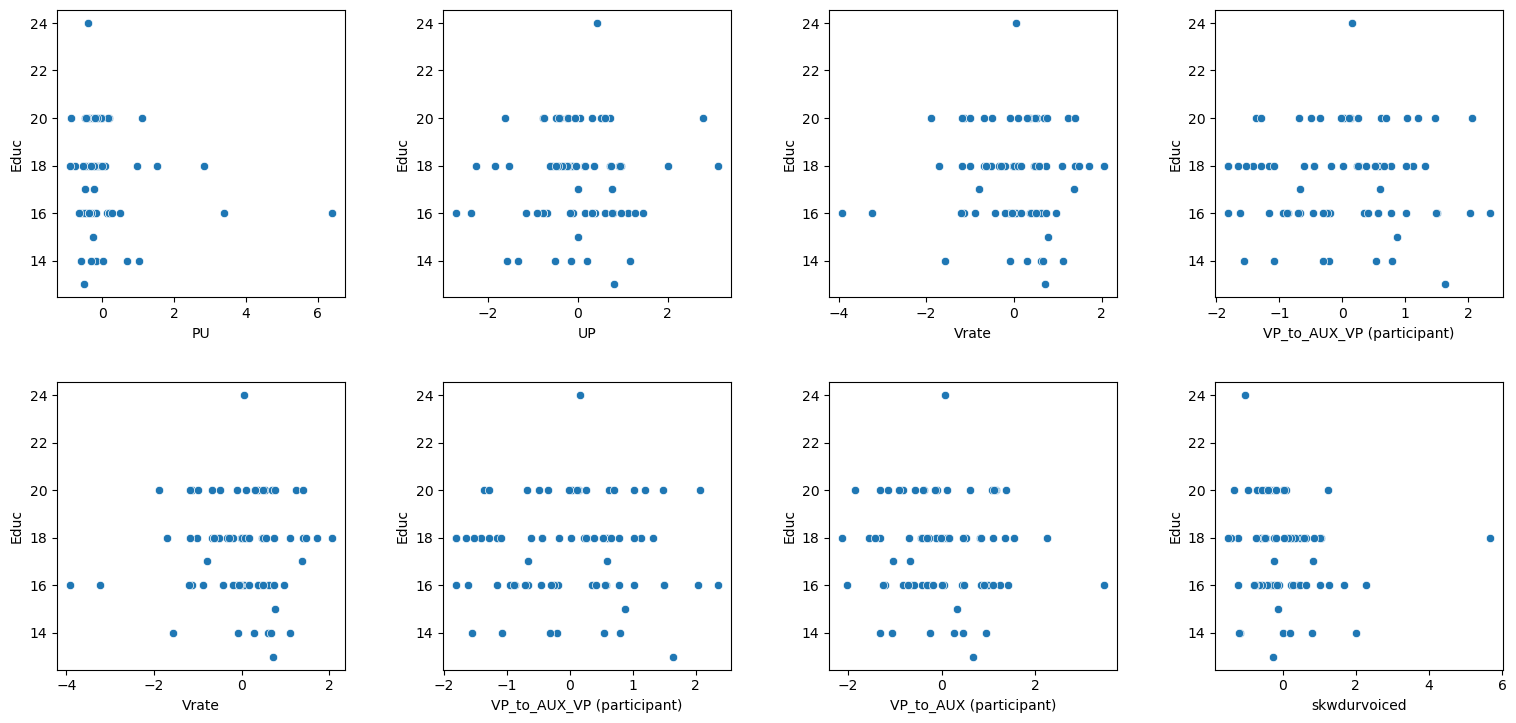

In [11]:
dataset = 'full_corrected.csv'
feats = [
    'PU', 'UP', 'Vrate', 'VP_to_AUX_VP (participant)', 'VP_to_AUX (participant)', 'skwdurvoiced', 'kurtosisdurvoiced', 'RatioVerb'
]

print('Age')
evaluate(dataset, 'Age_at_testing', feats, 'pTau_Positivity')
visualize(dataset, 'Age_at_testing', feats, 'pTau_Positivity')

print('Gender')
evaluate(dataset, 'Sex_Category', feats, 'pTau_Positivity')
visualize(dataset, 'Sex_Category', feats, 'pTau_Positivity')

print('Education')
evaluate(dataset, 'Educ', feats, 'pTau_Positivity')
visualize(dataset, 'Educ', feats, 'pTau_Positivity')